In [1]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
import tensorflow as tf
import os
import sys
import pandas as pd
import re
import random
import nltk
from nltk.tokenize.treebank import TreebankWordDetokenizer
from nltk.corpus import stopwords
nltk.download('stopwords')
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
book = open('prideandprejudice.txt', 'rb').read().decode(encoding='utf-8')

In [57]:
def tokenize(string):
    return re.compile('\w+').findall(string)

from collections import Counter

def word_freq(string): 
    text = tokenize(string.lower())
    c = Counter(text)           # compte les mots
    d = Counter(''.join(text))  # compte les lettres
    return (dict(c),dict(d))    

words, letters = word_freq(book) # dictionnaires

sumWords = sum(words.values())       
sumLetters = sum(letters.values())   

In [58]:
c = {}
for w in words:
    c[w] = {w : [words[w]/sumWords]}
    c.update(c[w])

In [59]:
df_words = pd.DataFrame.from_dict(c,orient='index').rename(columns = {0 : "proba"})
df_words["words"] = df_words.index
df_without_stop_words = df_words[~df_words['words'].isin(stopwords.words('english'))]
top_30_words = df_without_stop_words.sort_values(by=['proba'], ascending=False)[:30]

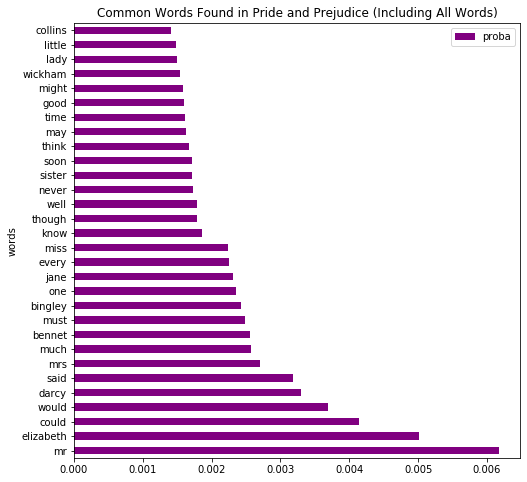

In [60]:
fig, ax = plt.subplots(figsize=(8, 8))

top_30_words.plot.barh(x="words",
                      y='proba',
                      ax=ax,
                      color="purple")

ax.set_title("Common Words Found in Pride and Prejudice (Including All Words)")

plt.show()

Voici les mots qu'on s'attend à retrouver. Ce sont les mots les plus courants dans le texte.

Liste de tous les caractères uniques présent dans le livre

In [3]:
caract = sorted(set(book)) 

Faisons un mappage de ces 87 caractères uniques, dans les deux sens (caractère -> index et index -> caractères) 

In [75]:
dico_caract_index = {i:j for j, i in enumerate(caract)}
caract_array = np.array(caract)
book_remappe = np.array([dico_caract_index[k] for k in book])

On utilise 80 caractères pour prédire le 81ème

In [5]:
seq_length = 80
examples_per_epoch = len(book)//(seq_length+1)

char_dataset = tf.data.Dataset.from_tensor_slices(book_remappe)

In [6]:
sequences = char_dataset.batch(seq_length+1, drop_remainder=True)

In [7]:
def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

dataset = sequences.map(split_input_target)

# Entrainons le modèle - Création de données d'entrainements

In [8]:
BATCH_SIZE = 64
BUFFER_SIZE = 10000
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
vocab_size = len(caract)
embedding_dim = 256
rnn_units = 1024
rnn_units_over_2  = 512
EPOCHS = 30

In [9]:
def build_model(vocab_size, embedding_dim, rnn_units,rnn_units_over_2, batch_size):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim,
                                  batch_input_shape=[batch_size, None]),
        tf.keras.layers.GRU(rnn_units,
                            return_sequences=True,
                            stateful=True,
                            recurrent_initializer='glorot_uniform'),
        tf.keras.layers.GRU(rnn_units_over_2,
                            return_sequences=True,
                            stateful=True,
                            recurrent_initializer='glorot_uniform'),
        tf.keras.layers.Dense(vocab_size)
    ])
    return model

def loss_function(labels, logits):
    return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

In [10]:
model = build_model(
    vocab_size=len(caract),
    embedding_dim=embedding_dim,
    rnn_units=rnn_units,
    rnn_units_over_2 = 512,
    batch_size=BATCH_SIZE)
model.compile(optimizer='adam', loss=loss_function)

On stocke les poids, afin de s'en resservir plus tard pour prédire du texte

In [40]:
checkpoint_dir = './checkpoint'
checkpoint_prefix = os.path.join(checkpoint_dir, "save_model_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

In [12]:
history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

Epoch 1/30
139/139 [==============================] - 442s 3s/step - loss: 2.5209
Epoch 2/30
139/139 [==============================] - 456s 3s/step - loss: 1.6754
Epoch 3/30
139/139 [==============================] - 465s 3s/step - loss: 1.3745
Epoch 4/30
139/139 [==============================] - 426s 3s/step - loss: 1.2500
Epoch 5/30
139/139 [==============================] - 472s 3s/step - loss: 1.1795
Epoch 6/30
139/139 [==============================] - 467s 3s/step - loss: 1.1278
Epoch 7/30
139/139 [==============================] - 938s 7s/step - loss: 1.0835
Epoch 8/30
139/139 [==============================] - 446s 3s/step - loss: 1.0409
Epoch 9/30
139/139 [==============================] - 404s 3s/step - loss: 1.0010
Epoch 10/30
139/139 [==============================] - 400s 3s/step - loss: 0.9612
Epoch 11/30
139/139 [==============================] - 400s 3s/step - loss: 0.9199
Epoch 12/30
139/139 [==============================] - 400s 3s/step - loss: 0.8778
Epoch 13/30
1

Nous pouvons désormais utiliser le modèle afin de prédire du texte

In [42]:
model = build_model(vocab_size, embedding_dim, rnn_units, rnn_units_over_2, batch_size=1)
model.load_weights(tf.train.latest_checkpoint("checkpoint"))
model.build(tf.TensorShape([1, None]))

In [76]:
def generate_text(model, start_string):

    num_generate = 300
    input_eval = [dico_caract_index[s] for s in start_string]
    input_eval = tf.expand_dims(input_eval, 0)

    text_generated = []


    temperature = 0.1

    model.reset_states()
    for i in range(num_generate):
        predictions = model(input_eval)
        predictions = tf.squeeze(predictions, 0)

        predictions = predictions / temperature
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()

        input_eval = tf.expand_dims([predicted_id], 0)
        text_generated.append(caract_array[predicted_id])

    return (start_string + ''.join(text_generated))

In [39]:
print(generate_text(model, start_string=u"A"))

Arcy was not so
palatable to your mother and sisters, though she foresaw little pleasure in the country. It
was spoken of again while they were at the door of Lydia's prospects of Mr.
     Wickham, when last at Netherfield for the truth, I was too like him, I should think it
occasional glance at home. Her heart will have to conceal it, from that very wish
which Elizabeth had received at the same time haughters have
been always at Longbourn."

A long dispute followed the less of her own ro


Calcul de la probabilité d'occurence d'un mot dans le livre